In [143]:
import chainer
from PIL import Image, ImageDraw, ImageFont
import csv
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
import easyocr
from manga_ocr import MangaOcr
from scipy.ndimage import rotate
from imutils.contours import sort_contours

import sys
sys.path.append('../../')

from kr.detector.centernet.resnet import Res18UnetCenterNet
from kr.classifier.softmax.mobilenetv3 import MobileNetV3
from kr.datasets import KuzushijiUnicodeMapping

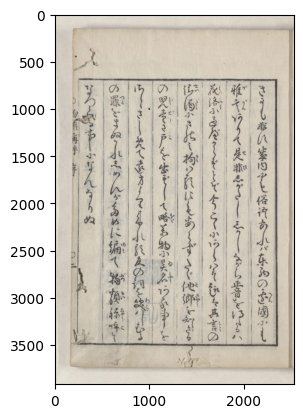

In [132]:
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'
filename = '/home/ec2-user/code/restor-ai-tion/data/full/brsk00000/images/brsk001_005.jpg'
image = Image.open(filename)
plt.imshow(image)
plt.show()

In [133]:
def predict(detector_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/detector/model_700.npz',
            classifier_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/classifier/model_1000.npz',
            image_filename='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'):

    # unicode <-> unicode index mapping
    mapping = KuzushijiUnicodeMapping()
    
    # load trained detector
    detector = Res18UnetCenterNet()
    chainer.serializers.load_npz(detector_model, detector)
    
    # load trained classifier
    classifier = MobileNetV3(out_ch=len(mapping))
    chainer.serializers.load_npz(classifier_model, classifier)
    
    # load image
    image = Image.open(image_filename)
    
    # character detection
    bboxes, bbox_scores = detector.detect(image)
    
    # character classification
    unicode_indices, scores = classifier.classify(image, bboxes)
    unicodes = [mapping.index_to_unicode(idx) for idx in unicode_indices]
    return unicodes, scores, bboxes, bbox_scores

In [134]:
unicodes, unicode_scores, bboxes, bbox_scores = predict(image_filename=filename)

In [182]:
font_path = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/font/NotoSansCJKjp-Regular.otf'
font = ImageFont.truetype(font_path, 60, encoding='utf-8')
text_color = 'rgb(255, 0, 0)'
true_color = 'rgb(0, 0, 255)'

def bbox_values(bbox):
    divisor = 1
    return int(bbox[0]/divisor), int(bbox[1]/divisor), int(bbox[2]/divisor), int(bbox[3]/divisor)

def visualize_preds(orig_filename, unicodes, unicode_scores, bboxes, bbox_scores, 
                    limit=-1,
                    verbose=False,
                    full_dataset='/home/ec2-user/code/restor-ai-tion/data/full',
                    same_image=True,
                    save_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    orig_img = Image.open(orig_filename)
    pred_img = Image.open(orig_filename)
    true_img = Image.open(orig_filename)
    pred_draw = ImageDraw.Draw(pred_img)
    true_draw = ImageDraw.Draw(true_img)
    if limit == -1:
        limit = len(unicodes)
    for (pred, uscore, bbox, bscore) in zip(unicodes[:limit], unicode_scores[:limit], bboxes[:limit], bbox_scores[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        if verbose:
            print(pred, label, uscore, x, y, w, h, bscore)

        
        pred_draw.text((x - 50, y - 10), label, fill=text_color, font = font)
        pred_draw.rectangle([(x, y), (w, h)], outline='blue', width=3)


    x = os.path.basename(orig_filename).replace('-', '_')
    true_image_availagle = False
    if len(x.split('_')) >= 2:
        true_image_available = True
        bookname = x.split('_')[0]
        if bookname.startswith('umgy'):
            bookname = 'umgy00000'
        elif bookname.startswith('hnsd'):
            bookanme = 'hnsd00000'
        elif bookname.startswith('brsk'):
            bookname = 'brsk00000'

        image_name = x.split('.')[0]
        csv_file = os.path.join(full_dataset, bookname, '{}_coordinate.csv'.format(bookname))
        print(csv_file)
        true_unicodes = []
        true_bboxes = []
        with open(csv_file) as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['Image'] == image_name:
                    uc = row['Unicode']
                    true_unicodes.append(chr(int(uc[2:], 16)))
                    true_bboxes.append([int(row['X']), int(row['Y']), int(row['Width']), int(row['Height'])])

        print(len(true_unicodes), len(unicodes))
        if same_image:
            dimg = pred_draw
        else:
            dimg = true_draw
        for (uc, bbox) in zip(true_unicodes, true_bboxes):
            x, y, w, h = bbox_values(bbox)
            w = w + x
            h = h + y
            if verbose:
                print(pred, label, uscore, x, y, w, h, bscore)
    
            
            dimg.text((x + 100, y - 10), uc, fill=true_color, font = font)
            dimg.rectangle([(x, y), (w, h)], outline='green', width=4)            
                

    if same_image or not true_image_available:
        plt.figure()
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        basename = os.path.basename(orig_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_filename]
    else:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(true_img)
        plt.title('True')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        
        basename = os.path.basename(orig_filename)
        save_true_filename = os.path.join(save_folder, 'true_{}'.format(basename))
        true_img.save(save_true_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_true_filename, save_filename]

    return viz_filenames


/home/ec2-user/code/restor-ai-tion/data/full/brsk00000/brsk00000_coordinate.csv
165 157


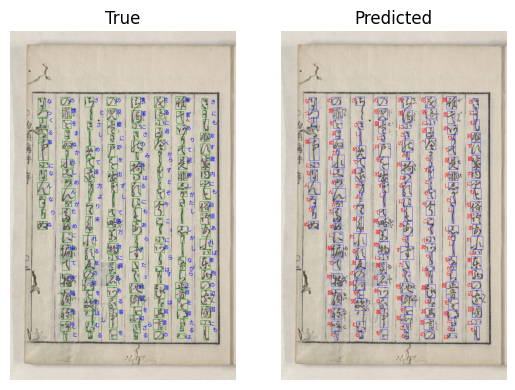

In [184]:
pred_filenames = visualize_preds(filename,
                                 unicodes, unicode_scores, bboxes, bbox_scores, 
                                 same_image=False,
                                 limit=-1, verbose=False)
pred_filename = pred_filenames[0]

In [185]:
' '.join([chr(int(c[2:], 16)) for c in unicodes])

'の を を の す 友 を 内 て 物 れ を 非 花 に ず 俗 ゞ に 得 ら 清 る の あ た た ぞ る る ぬ 語 今 あ 其 れ 薬 て の て 趣 べ 他 是 て あ 児 し 東 あ あ の 物 き 雅 を ん も 濁 ん た 畿 れ 類 詞 西 な こ 略 言 さ 才 名 が に は 遠 称 ず 国 な 童 な つ ま ら 郷 な 過 み 言 り の 出 罪 ら も め は 非 し 笑 に 辺 拘 し す 来 ば を 知 ず る り と め り ゝ に は 洛 は ざ に し 呼 さ ぬ 小 し 事 も む し に た に よ 編 も が さ 戸 め に 普 ら る 事 異 と し か に か る く'

In [186]:
def get_text(chars, boxes, limit=-1):
    if limit == -1:
        limit = len(chars)

    ubox_tuples = [(chr(int(c[2:], 16)), bbox_values(box)) for (c, box) in zip(chars[:limit], boxes[:limit])]
    print(ubox_tuples)

In [187]:
get_text(unicodes, bboxes, limit=10)

[('の', (1082, 740, 1190, 837)), ('を', (588, 997, 685, 1093)), ('を', (1875, 3009, 1992, 3125)), ('の', (823, 2680, 934, 2785)), ('す', (2136, 1252, 2239, 1381)), ('友', (837, 2563, 948, 2671)), ('を', (1109, 1405, 1207, 1552)), ('内', (2138, 1566, 2236, 1654)), ('て', (582, 2566, 664, 2684)), ('物', (1087, 2363, 1215, 2499))]


In [188]:
int_boxes = np.array([bbox_values(b) for b in bboxes[:10]])
print(int_boxes)

[[1082  740 1190  837]
 [ 588  997  685 1093]
 [1875 3009 1992 3125]
 [ 823 2680  934 2785]
 [2136 1252 2239 1381]
 [ 837 2563  948 2671]
 [1109 1405 1207 1552]
 [2138 1566 2236 1654]
 [ 582 2566  664 2684]
 [1087 2363 1215 2499]]


In [189]:
def bbox_values2(bbox):
    divisor = 1
    b = bbox/divisor
    return int(b[0]), int(b[1]), int(abs(b[0]-b[2])), int(abs(b[1]-b[3]))

def get_unicode(uc):
    return [chr(int(c[2:],16)) for c in uc]

scaled_bboxes = [bbox_values2(b) for b in bboxes]



print(scaled_bboxes[:10])
print(' '.join(get_unicode(unicodes)))


# uc = [chr(int(c[2:], 16)) for c in unicodes]
# tb = list(zip(*sorted(zip(uc, scaled_bboxes), key=lambda b: -b[1][0]+b[1][1], reverse=False)))
# print(' '.join(list(tb)[0]))
# for i in range(10):
#     print(tb[0][i], tb[1][i])
# # rl = list(zip(*sorted(zip(*tb), key=lambda b: b[1][1], reverse=False)))
# # print(' '.join(list(rl)[0]))
# # print(rl[0][0], tb[1][0])
# # print(rl[0][1], rl[1][1])

# arr = np.array(bboxes)
# r = (arr[:, 0]**2 + arr[:, 1] **2)**0.5
# indices = np.argsort(r)
# print(indices)
# ordered_chars = []
# for i in indices:
#     c = unicodes[i]
#     ordered_chars.append(chr(int(c[2:], 16)))
# print(ordered_chars)



[(1082, 740, 107, 96), (588, 997, 97, 95), (1875, 3009, 117, 116), (823, 2680, 111, 105), (2136, 1252, 102, 129), (837, 2563, 110, 107), (1109, 1405, 97, 146), (2138, 1566, 97, 87), (582, 2566, 82, 118), (1087, 2363, 127, 135)]
の を を の す 友 を 内 て 物 れ を 非 花 に ず 俗 ゞ に 得 ら 清 る の あ た た ぞ る る ぬ 語 今 あ 其 れ 薬 て の て 趣 べ 他 是 て あ 児 し 東 あ あ の 物 き 雅 を ん も 濁 ん た 畿 れ 類 詞 西 な こ 略 言 さ 才 名 が に は 遠 称 ず 国 な 童 な つ ま ら 郷 な 過 み 言 り の 出 罪 ら も め は 非 し 笑 に 辺 拘 し す 来 ば を 知 ず る り と め り ゝ に は 洛 は ざ に し 呼 さ ぬ 小 し 事 も む し に た に よ 編 も が さ 戸 め に 普 ら る 事 異 と し か に か る く


In [190]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(img, [5, 5], 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts[:2]
# cv2.boundingRect(cnts[0])
# cnts = imutils.contours.sort_contours(cnts, method='left-to-right')[0]
# print(cnts[:1])

(array([[[2528, 3753]],
 
        [[2528, 3755]],
 
        [[2529, 3755]],
 
        [[2531, 3757]],
 
        [[2533, 3757]],
 
        [[2532, 3757]],
 
        [[2530, 3755]],
 
        [[2532, 3753]],
 
        [[2533, 3753]]], dtype=int32),
 array([[[1451, 3704]],
 
        [[1450, 3705]],
 
        [[1450, 3711]],
 
        [[1449, 3712]],
 
        [[1449, 3715]],
 
        [[1448, 3716]],
 
        [[1448, 3723]],
 
        [[1449, 3724]],
 
        [[1449, 3731]],
 
        [[1448, 3732]],
 
        [[1448, 3734]],
 
        [[1447, 3735]],
 
        [[1447, 3736]],
 
        [[1445, 3738]],
 
        [[1443, 3738]],
 
        [[1442, 3739]],
 
        [[1441, 3738]],
 
        [[1439, 3738]],
 
        [[1441, 3738]],
 
        [[1443, 3740]],
 
        [[1442, 3739]],
 
        [[1443, 3738]],
 
        [[1444, 3738]],
 
        [[1445, 3739]],
 
        [[1447, 3737]],
 
        [[1447, 3736]],
 
        [[1448, 3735]],
 
        [[1448, 3732]],
 
        [[1449, 3731]],
 

In [191]:
def ocr_image(tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds',
                    image_filename=filename):
    # new image attempt.
    tgt_filename = os.path.join(tgt_folder, 'ocr_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))
    pred_draw = ImageDraw.Draw(pred_image)
    limit = len(unicodes)
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_draw.text((x-20, y-10), label, fill=text_color, font = font)
    pred_image.save(tgt_filename)    
    
    ocr_img = cv2.imread(tgt_filename)
    plt.imshow(ocr_img)
    return tgt_filename

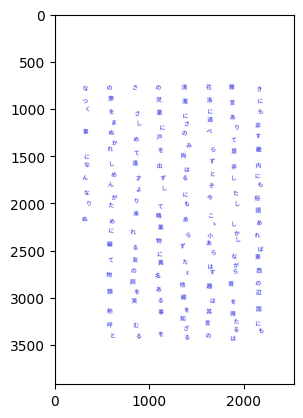

In [192]:
ocr_filename = ocr_image(image_filename=filename)

In [193]:
def easyocr_prediction(ocr_filename, detail=0):
    ## easyocr on modern japenese
    reader = easyocr.Reader(['ja'])
    result = reader.readtext(ocr_filename, detail = detail)
    return result

In [194]:
result = easyocr_prediction(pred_filename, detail=0)
' '.join(result)

'な 晴 \'花 刷 き 罪 : 孟 藁 も を さ 童 に あ る ま さ 過 貞 に り 排 事 戸 て は ・ に か 碧 て を 物 区 @ 幾 な 遠 ず  は 峠 め と 方 ず る な ぞ @ も が り に " り た 四て も @ め 来 あ 震 あ 万 回 ら か 礼 る ば 職 て ラ友 厚 た ら な 、 \' ジ ほ 《 露 福 頼 を 位 悪 瞳 郷 { 葉 る 回は 充 称 口は 事 回を 酢 国 知 ~ペ む 岡ざら 件 右 も る を る は お ※愛 ぼ'

In [195]:
# manga-ocr
def mangaocr_prediction(tgt_filename):
    mocr = MangaOcr()
    text = mocr(tgt_filename)
    return text

In [196]:
text = mangaocr_prediction(pred_filename)
print(text)

2023-10-08 22:04:05.848 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
/home/ec2-user/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2023-10-08 22:04:07.713 | INFO     | manga_ocr.ocr:__init__:19 - Using CUDA
2023-10-08 22:04:07.879 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


そして、それはそうだけどなんですから、そんなことができないですよね。そのまま、まだまだそういうことです。


In [197]:
# new image (rotated) attempt.
def rot(dim_orig, dim_rot, xy, angle=90):
    org_center = (np.array(dim_orig[:2][::-1])-1)/2.
    rot_center = (np.array(dim_rot[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a) ])
    return new+rot_center

def rotate_image(image_filename, ocr_filename, tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    tgt_rot_filename = os.path.join(tgt_folder, 'ocr_rotated_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(image_filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_rot_image = Image.new('RGB', (n, m), color=(255,255,255,127))
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))

    pred_draw = ImageDraw.Draw(pred_image)
    pred_rot_draw = ImageDraw.Draw(pred_rot_image)
    limit = len(unicodes)
    
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        xr, yr = rot((n, m), (m, n), (x,y))
        # print(x, y, xr, yr)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_rot_draw.text((xr, yr), label, fill=text_color, font = font)

    pred_rot_image.save(tgt_rot_filename)    
    
    return tgt_rot_filename

def vizualize_ocrs(ocr_filename, ocr_rot_filename):
    ocr_image = cv2.imread(ocr_filename)
    ocr_rot_image = cv2.imread(ocr_rot_filename)
    
    plt.figure(figsize=(30,15))
    plt.subplot(1,2,1)
    plt.imshow(ocr_image)
    plt.title('regular')
    
    plt.subplot(1,2,2)
    plt.imshow(ocr_rot_image)
    plt.title('rotated by 90')
    plt.show()

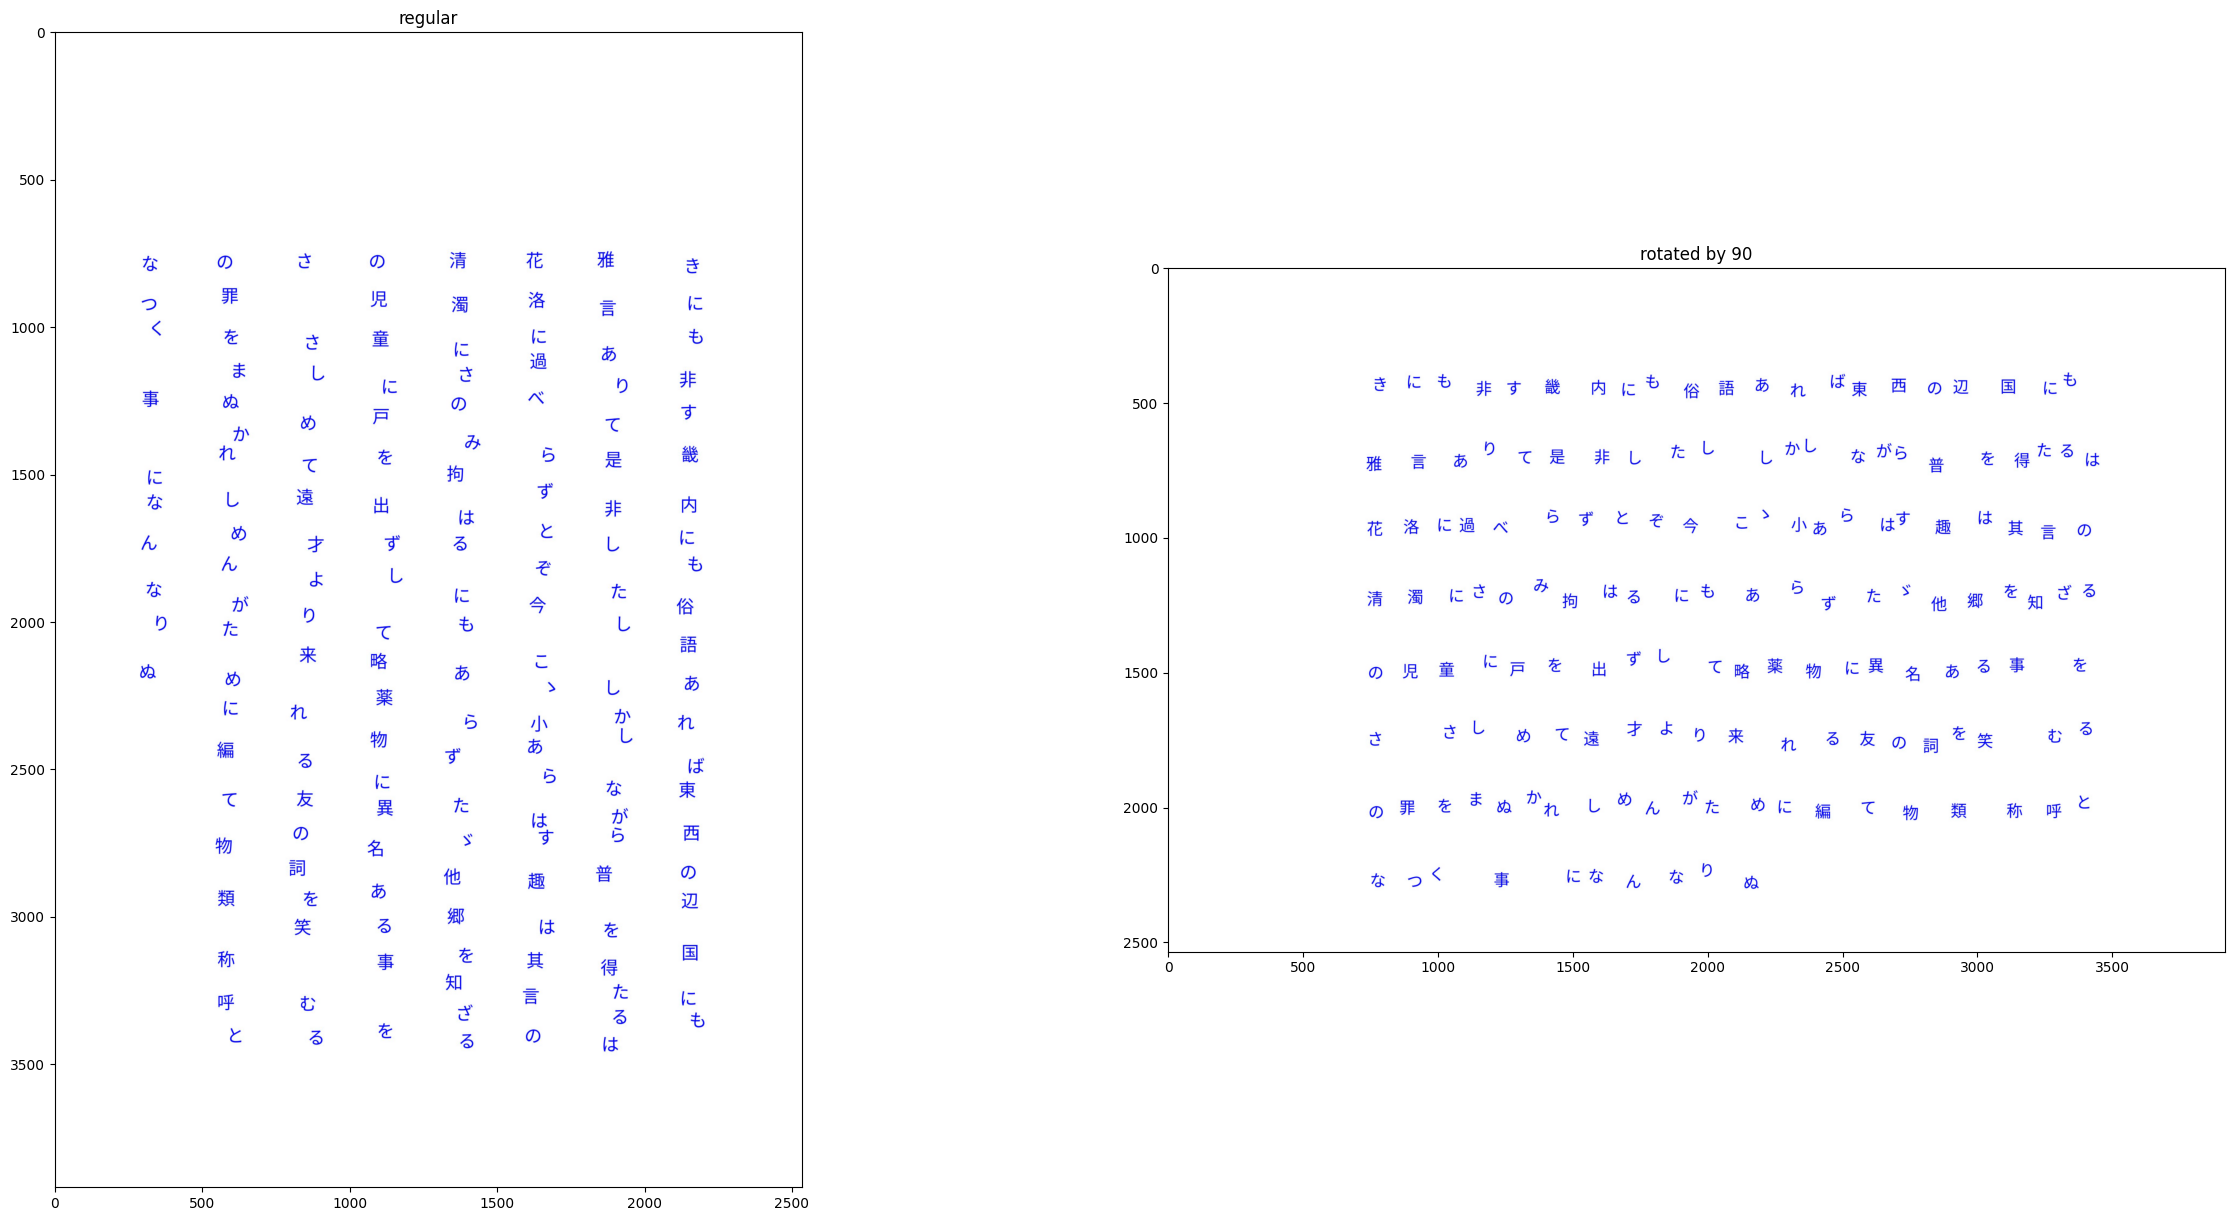

In [198]:
ocr_rot_filename = rotate_image(filename, ocr_filename)
vizualize_ocrs(ocr_filename, ocr_rot_filename)

In [199]:
result = easyocr_prediction(ocr_rot_filename, detail=1)
s = []
for x in result:
    s.append(x[1])
''.join(s)

'き にも非す 幾 内にも 俗 語 あ れ ば東 西 の辺 国 にも雅言 あり て是 非し たしながら普は花 浴 に過 べらず とぞ 今澤こ〉らはす   .の清 滑 にさ のみ 均にも あら他郷 を知ざるの 児莉童に戸 を澤出 ずして 略 薬 物 に異 名 ある 事をささし め て遠 才よ り 来澤れ莉る 友 の詞の 罪 を まぬ かれ し めんめに編 て物 類 称呼 とな っく事にな ん なりし かしを 得たるは 其 言小あはるず た ぶむ るを笑がた'

In [200]:
text = mangaocr_prediction(ocr_rot_filename)
print(text)

2023-10-08 22:04:13.334 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2023-10-08 22:04:15.118 | INFO     | manga_ocr.ocr:__init__:19 - Using CUDA
2023-10-08 22:04:15.287 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


そのため、これからのサイトでありますが、
